In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# load in dataset
(train_images, train_labels) , (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# create a validation set from the training data (80-20 split)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

train_images = preprocess_image_input(train_images)
val_images = preprocess_image_input(val_images)
test_images = preprocess_image_input(test_images)

In [3]:
# function definintions to create model
def feature_extractor(inputs):
  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                        include_top=False,
                        weights='imagenet')(inputs)
  return feature_extractor

def classifier(inputs):
  x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation="relu")(x)
  x = tf.keras.layers.Dense(512, activation="relu")(x)
  x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
  return x

def final_model(inputs):
  resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
  resnet_feature_extractor = feature_extractor(resize)
  classification_output = classifier(resnet_feature_extractor)
  return classification_output

def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
  model.compile(optimizer='sgd',
                loss='sparse_categorical_crossentropy',
                metrics =['accuracy'])
  return model

# compile the model and show a summary
model = define_compile_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification (Dense)               │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,215,818 (100.01 MB)

 Trainable params: 26,162,698 (99.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [4]:
# train the model and print test results
history = model.fit(train_images, train_labels,
                    epochs=10,
                    validation_data = (val_images, val_labels),
                    batch_size=32
                    )

loss, accuracy = model.evaluate(test_images, test_labels, batch_size=32)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 421s 309ms/step - accuracy: 0.7848 - loss: 0.6445 - val_accuracy: 0.9047 - val_loss: 0.2847
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 384s 307ms/step - accuracy: 0.9650 - loss: 0.1096 - val_accuracy: 0.9417 - val_loss: 0.1710
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 384s 307ms/step - accuracy: 0.9879 - loss: 0.0395 - val_accuracy: 0.9494 - val_loss: 0.1664
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 442s 307ms/step - accuracy: 0.9938 - loss: 0.0215 - val_accuracy: 0.9487 - val_loss: 0.1842
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 384s 307ms/step - accuracy: 0.9959 - loss: 0.0144 - val_accuracy: 0.9498 - val_loss: 0.1843
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 436s 302ms/step - accuracy: 0.9974 - loss: 0.0092 - val_accuracy: 0.9542 - val_loss: 0.1721
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 387s 306ms/step - accuracy: 0.9981 - loss: 0.0073 - val_accuracy: 0.9513 - val_loss: 0.1904
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 424s 292ms/step - ac

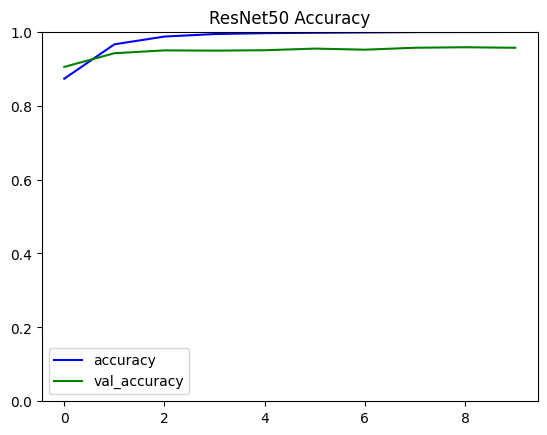

In [5]:
# utility to display training and validation curves
def plot_metrics(metric_name, title):
  plt.title(title)
  plt.ylim(0,1)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
  plt.legend()

plot_metrics("accuracy", "ResNet50 Accuracy")

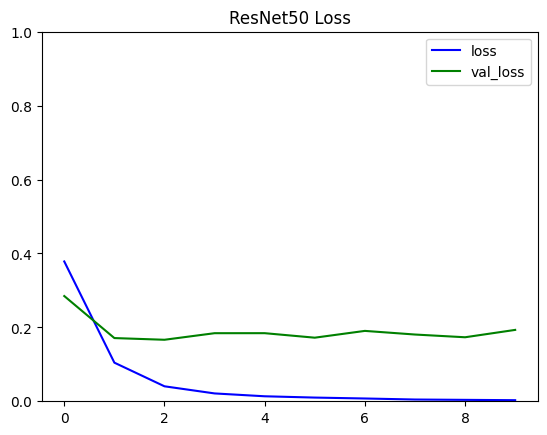

In [6]:
plot_metrics("loss", "ResNet50 Loss")

In [13]:
# make predictions on the test data
y_pred = model.predict(test_images)

y_pred = np.argmax(y_pred, axis=1)
y_true = test_labels.flatten()

# compute performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step

Performance Metrics:
Accuracy: 0.9555
Precision: 0.9558
Recall: 0.9555
F1 Score: 0.9554
